In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

seasons_stats = pd.read_csv("Seasons_Stats.csv")
nba_positions_full = seasons_stats[seasons_stats['Year'] == 2017][[
    'Player', 'Tm', 'G', 'Pos', 'TOV%', 'TRB%', 'AST%', 'FG%'
]].copy()
nba_positions_full.columns = ['Player', 'Team', 'Games', 'Position', 'TurnoverPct', 'ReboundPct', 'AssistPct', 'FieldGoalPct']
nba_positions_full['FieldGoalPct'] = nba_positions_full['FieldGoalPct'] * 100
position_map = {
    "C": "Center",
    "PF": "PowerForward",
    "PF-C": "PowerForward_Center",
    "PG": "PointGuard",
    "SF": "SmallForward",
    "SG": "ShootingGuard"
}
nba_positions_full['Position'] = nba_positions_full['Position'].map(position_map)
nba_positions = nba_positions_full.groupby(['Player', 'Position']).agg({
    'Games': 'sum',
    'TurnoverPct': 'mean',
    'ReboundPct': 'mean',
    'AssistPct': 'mean',
    'FieldGoalPct': 'mean'
}).reset_index()
nba_positions = nba_positions[
    (nba_positions['Position'].isin(['Center', 'PointGuard', 'ShootingGuard'])) & 
    (nba_positions['Games'] > 10)
].dropna().reset_index(drop=True)
stats_matrix = nba_positions[['TurnoverPct', 'ReboundPct', 'AssistPct', 'FieldGoalPct']].values
k_means = KMeans(n_clusters=3, max_iter=100, n_init=1000, random_state=2)
k_means.fit(stats_matrix)
center_cluster = k_means.predict(stats_matrix[nba_positions['Position'] == 'Center'])[0]
dists_from_centre = np.sqrt(np.sum((stats_matrix - k_means.cluster_centers_[k_means.labels_])**2, axis=1))
nba_positions['Cluster'] = k_means.labels_
nba_positions['Dist'] = dists_from_centre
nba_positions = nba_positions[
    ((nba_positions['Cluster'] == center_cluster) & (nba_positions['Position'] == 'Center')) |
    ((nba_positions['Cluster'] != center_cluster) & (nba_positions['Position'] != 'Center'))
]
centers = nba_positions[nba_positions['Position'] == 'Center'].nsmallest(50, 'Dist')
guards = nba_positions[nba_positions['Position'] != 'Center'].groupby('Position').apply(lambda x: x.sample(min(len(x), 50), random_state=2)).reset_index(drop=True)
nba_positions = pd.concat([centers, guards]).sort_values('Position').reset_index(drop=True)
nba_positions = nba_positions.drop(columns=['Cluster', 'Dist'])
nba_positions_full.to_csv("nba_positions_full.tsv", sep='\t', index=False)
nba_positions.to_csv("nba_positions.tsv", sep='\t', index=False)

C:\Users\ethan\.conda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [2]:
all_seasons = pd.read_csv("all_seasons.csv")
stats_columns = ['player_name', 'gp', 'ts_pct', 'ast_pct', 'reb', 'pts']
all_seasons_stats = all_seasons[stats_columns].dropna().copy()
stats_matrix = all_seasons_stats[['ts_pct', 'ast_pct', 'reb', 'pts']].values
k_means = KMeans(n_clusters=3, max_iter=100, n_init=1000, random_state=2)
k_means.fit(stats_matrix)
all_seasons_stats['PositionCluster'] = k_means.labels_
position_map = {0: 'Guard', 1: 'Forward', 2: 'Center'}
all_seasons_stats['Position'] = all_seasons_stats['PositionCluster'].map(position_map)
all_seasons = all_seasons.merge(all_seasons_stats[['player_name', 'Position']], on='player_name', how='left')
all_seasons.to_csv("all_seasons_with_positions.csv", index=False)
all_seasons.head()

,Unnamed: 0,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,...,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,Position
0,0,Randy Livingston,HOU,22,193.04,94.800728,Louisiana State,USA,1996,2,...,1.5,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996-97,Center
1,0,Randy Livingston,HOU,22,193.04,94.800728,Louisiana State,USA,1996,2,...,1.5,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996-97,Center
2,0,Randy Livingston,HOU,22,193.04,94.800728,Louisiana State,USA,1996,2,...,1.5,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996-97,Forward
3,0,Randy Livingston,HOU,22,193.04,94.800728,Louisiana State,USA,1996,2,...,1.5,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996-97,Center
4,0,Randy Livingston,HOU,22,193.04,94.800728,Louisiana State,USA,1996,2,...,1.5,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996-97,Center


In [8]:
all_seasons_with_positions = pd.read_csv("processed_all_seasons.csv")
shooting_guards_only = all_seasons_with_positions[all_seasons_with_positions['Position'] == 'ShootingGuard']
shooting_guards_only.to_csv("shooting_guards_only.csv", index=False)

shooting_guards_only.head()

,Unnamed: 0,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,...,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,Position
2,281,tim hardaway,MIA,30,182.88,88.45044,Texas-El Paso,USA,1989,1,...,3.4,8.6,8.9,0.018,0.083,0.264,0.532,0.404,1996-97,ShootingGuard
4,557,tim hardaway,MIA,31,182.88,88.45044,Texas-El Paso,USA,1989,1,...,3.7,8.3,8.1,0.019,0.094,0.254,0.530,0.401,1997-98,ShootingGuard
12,1189,tim hardaway,MIA,32,182.88,88.45044,Texas-El Paso,USA,1989,1,...,3.2,7.3,7.2,0.011,0.088,0.263,0.511,0.383,1998-99,ShootingGuard
13,1440,tim hardaway,MIA,33,182.88,88.45044,Texas-El Paso,USA,1989,1,...,2.9,7.4,7.4,0.018,0.083,0.227,0.500,0.368,1999-00,ShootingGuard
21,1795,jamal crawford,CHI,21,195.58,90.71840,Michigan,USA,2000,1,...,1.5,2.3,-14.1,0.010,0.092,0.178,0.442,0.235,Jan-00,ShootingGuard


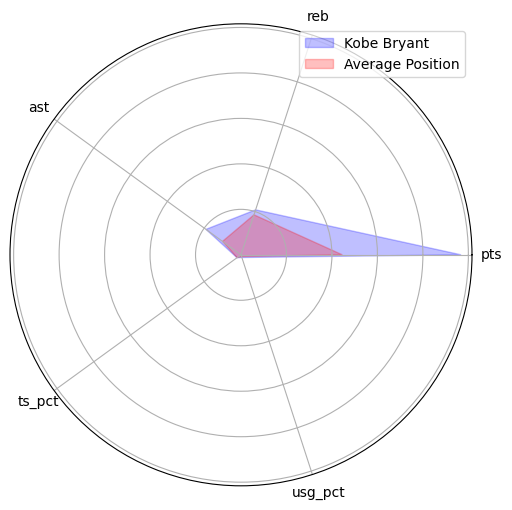

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

all_seasons = pd.read_csv("all_seasons_with_positions.csv")
kobe_stats = all_seasons[all_seasons['player_name'] == 'Kobe Bryant']
position_stats = all_seasons[(all_seasons['Position'] == kobe_stats['Position'].values[0]) & (all_seasons['season'] == kobe_stats['season'].values[0])]
categories = ['pts', 'reb', 'ast', 'ts_pct', 'usg_pct']
kobe_values = kobe_stats[categories].mean().values
position_values = position_stats.groupby('player_name')[categories].mean().values.mean(axis=0)
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
kobe_values = np.concatenate((kobe_values, [kobe_values[0]]))
position_values = np.concatenate((position_values, [position_values[0]]))
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, kobe_values, color='blue', alpha=0.25, label='Kobe Bryant')
ax.fill(angles, position_values, color='red', alpha=0.25, label='Average Position')
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
plt.legend(loc='upper right')
plt.show()


NameError: name 'sns' is not defined

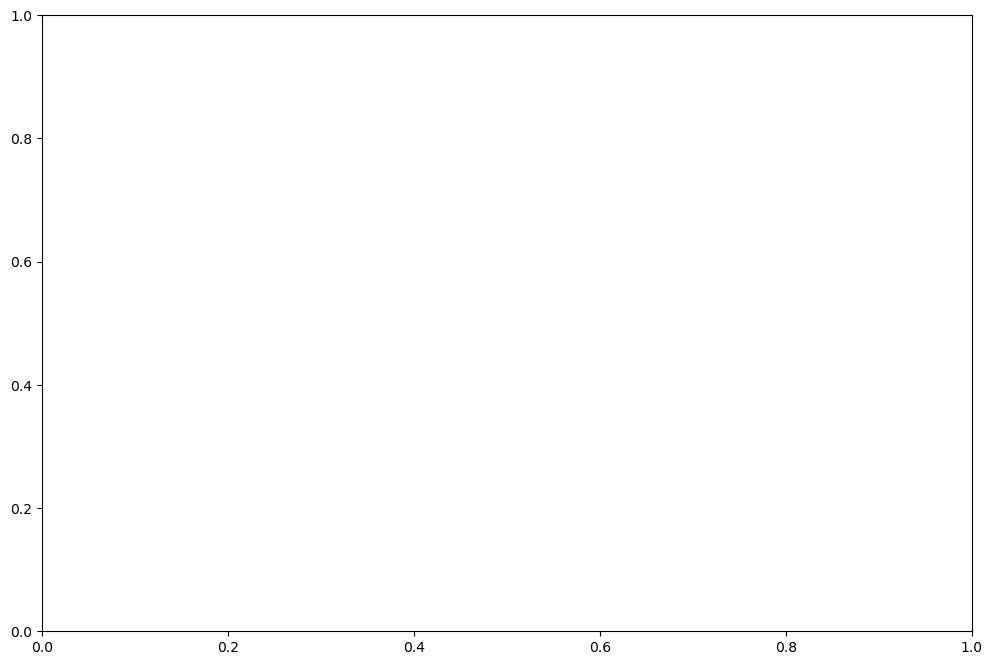

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

all_seasons = pd.read_csv("all_seasons_with_positions.csv")
players_to_compare = ['Kobe Bryant', 'Allen Iverson', 'Dwyane Wade', 'Tracy McGrady']
comparison_stats = all_seasons[all_seasons['player_name'].isin(players_to_compare)]
comparison_stats = comparison_stats.groupby('player_name')[['pts', 'reb', 'ast', 'ts_pct', 'usg_pct']].mean().reset_index()
comparison_stats_melted = comparison_stats.melt(id_vars='player_name', var_name='Metric', value_name='Average Value')
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=comparison_stats_melted, x='Metric', y='Average Value', hue='player_name', palette='muted')
plt.title('Performance Comparison: Kobe Bryant vs. Top Guards')
plt.ylabel('Average Value')
plt.show()


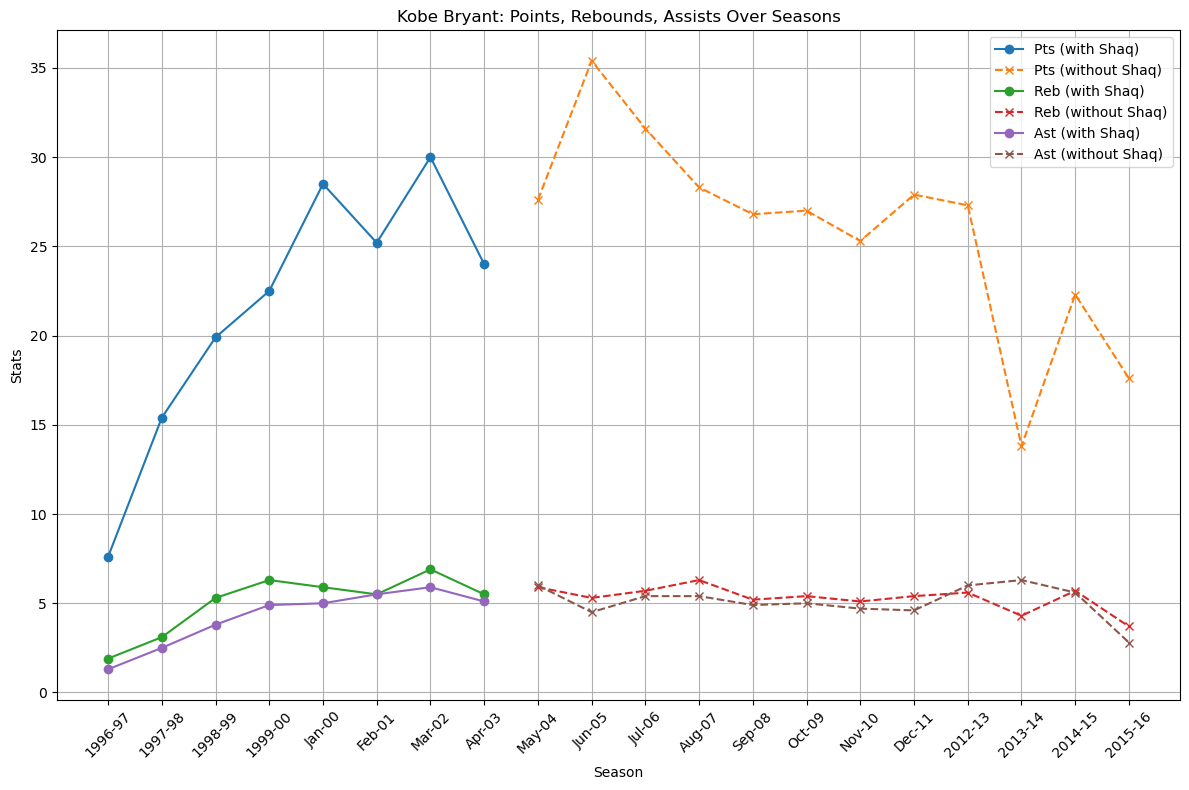

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('lakers_kobe_years_significant.csv')
kobe_data = df[df['player_name'] == 'Kobe Bryant']
shaq_data = df[df['player_name'] == 'Shaquille O\'Neal']['season'].tolist()

plt.figure(figsize=(12, 8))

for stat in ['pts', 'reb', 'ast']:
    with_shaq = kobe_data[kobe_data['season'].isin(shaq_data)]
    without_shaq = kobe_data[~kobe_data['season'].isin(shaq_data)]
    
    plt.plot(with_shaq['season'], with_shaq[stat], label=f'{stat.capitalize()} (with Shaq)', linestyle='-', marker='o')
    plt.plot(without_shaq['season'], without_shaq[stat], label=f'{stat.capitalize()} (without Shaq)', linestyle='--', marker='x')

plt.xlabel('Season')
plt.ylabel('Stats')
plt.title('Kobe Bryant: Points, Rebounds, Assists Over Seasons')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('kobe_stats_over_seasons.png')
plt.show()

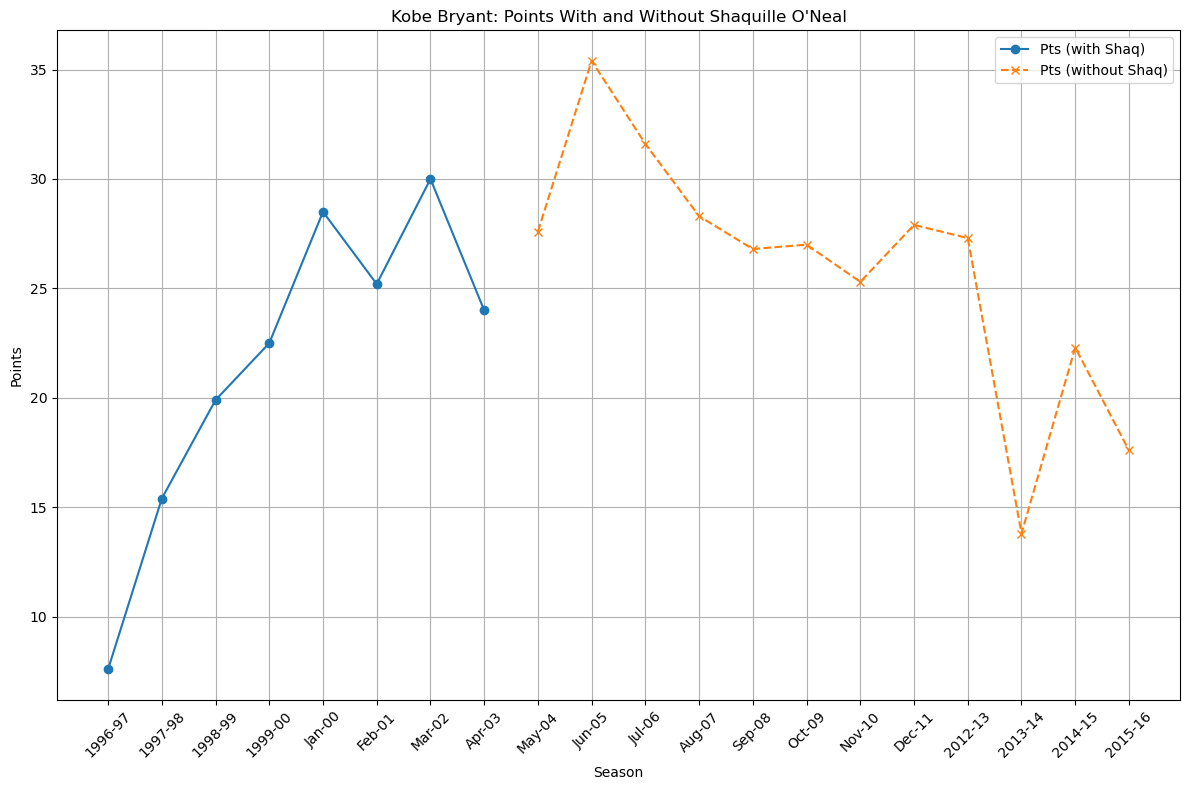

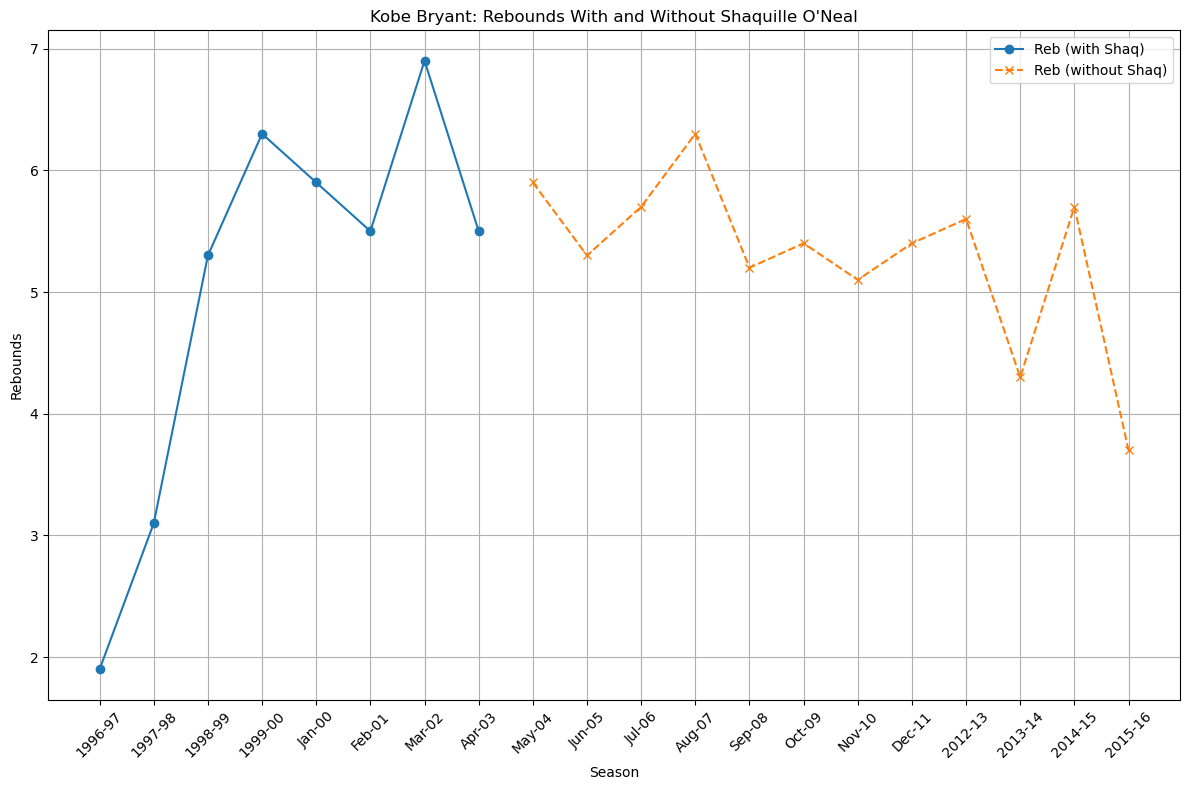

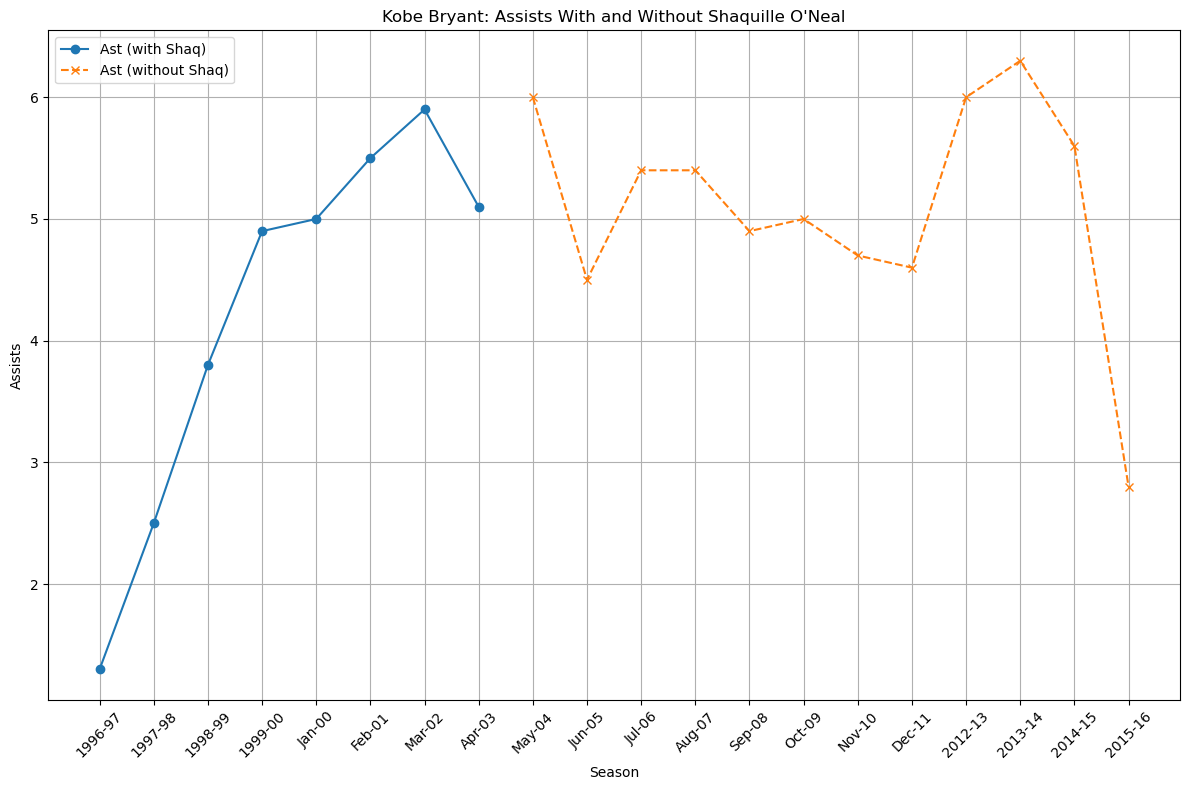

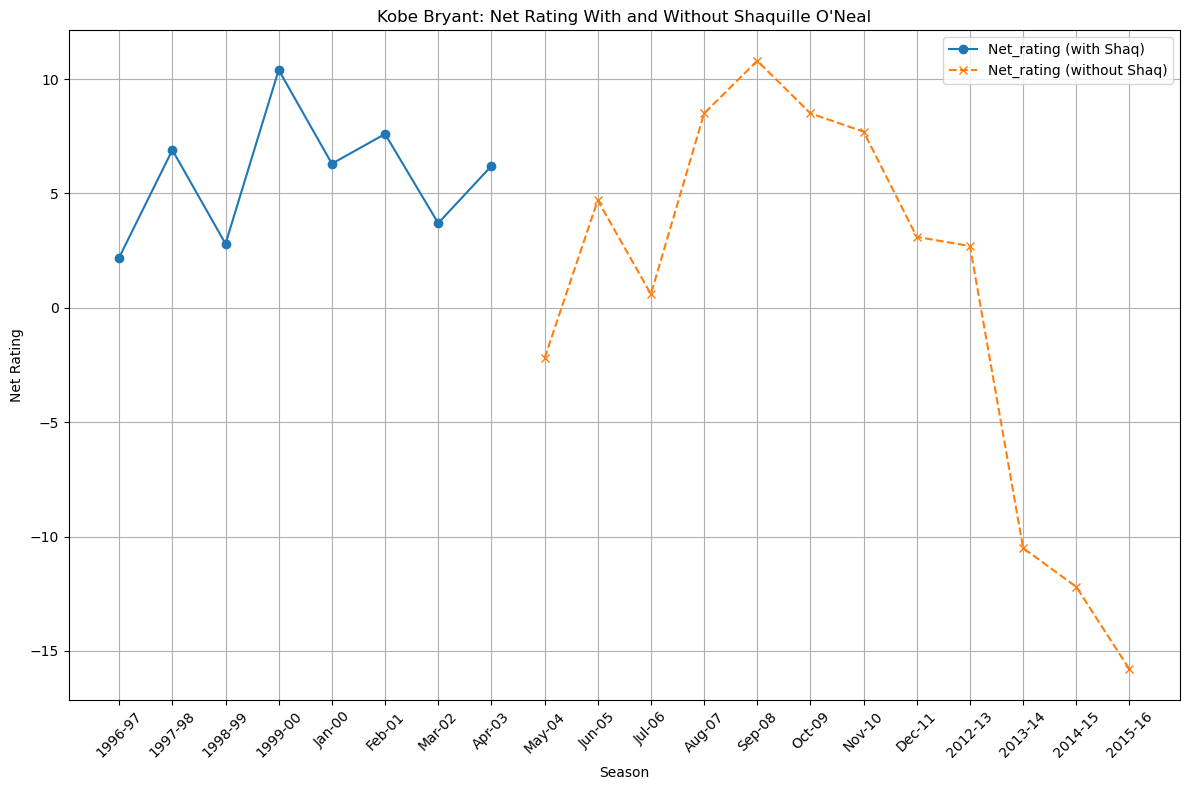

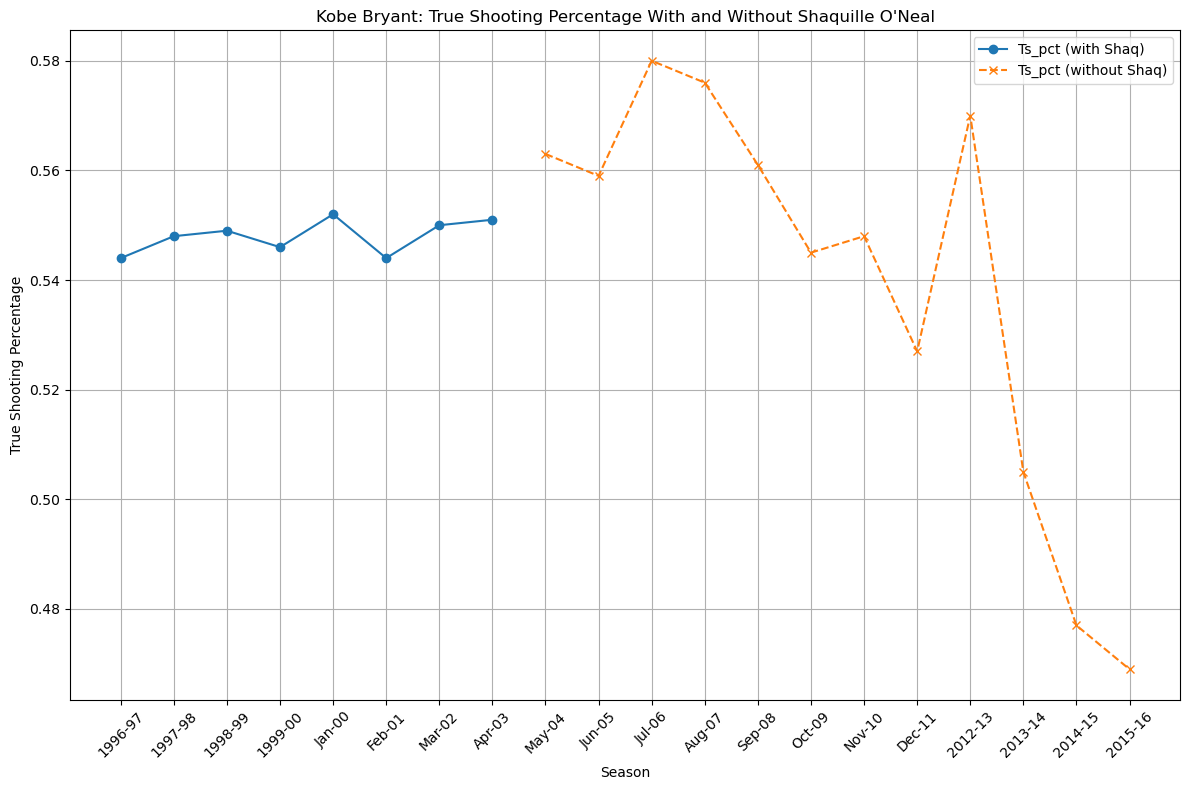

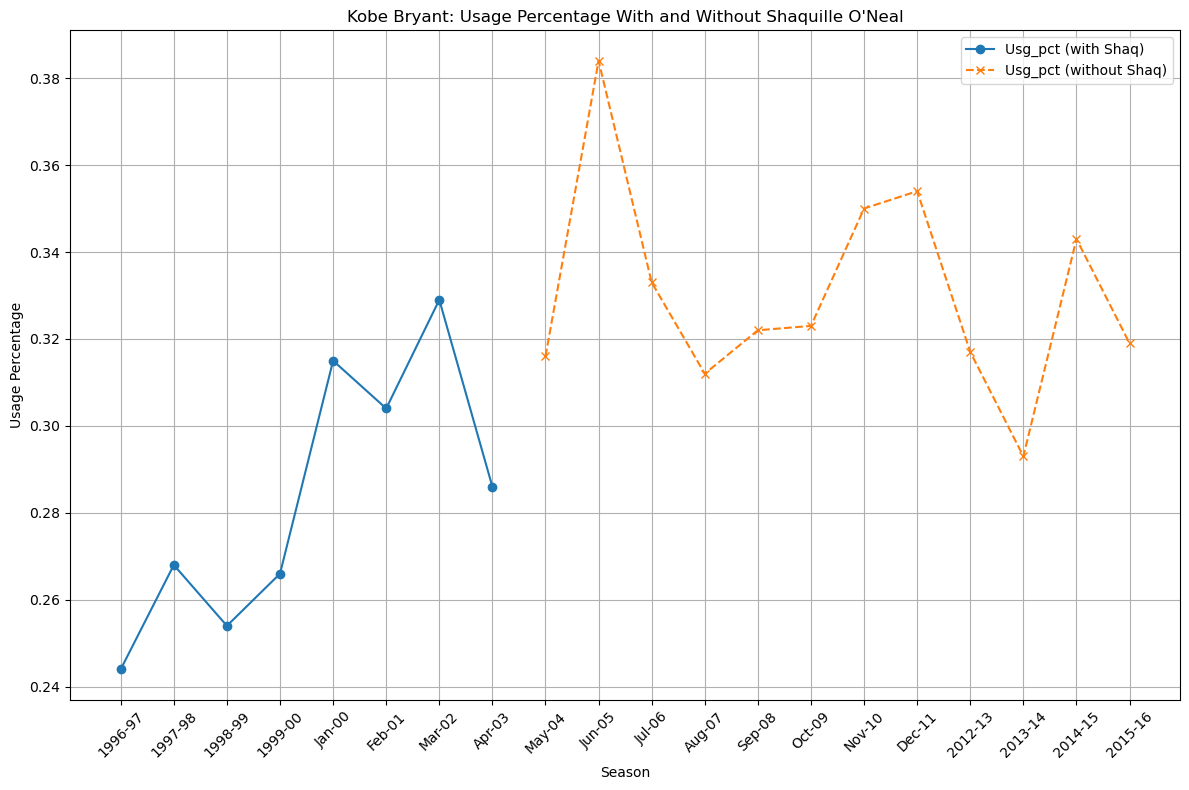

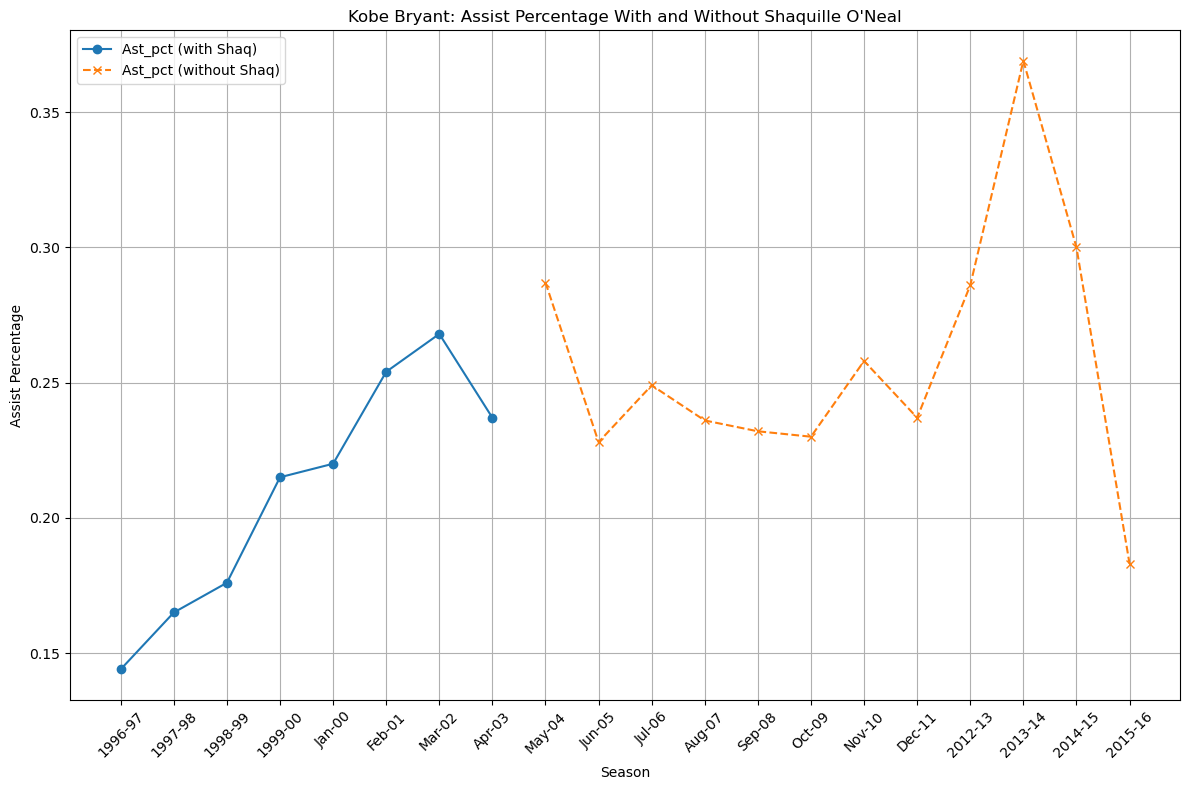

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('lakers_kobe_years_significant.csv')

kobe_data = df[df['player_name'] == 'Kobe Bryant']
shaq_data = df[df['player_name'] == 'Shaquille O\'Neal']['season'].tolist()

def plot_stat_with_and_without_shaq(stat, ylabel, title, filename):
    with_shaq = kobe_data[kobe_data['season'].isin(shaq_data)]
    without_shaq = kobe_data[~kobe_data['season'].isin(shaq_data)]
    
    plt.figure(figsize=(12, 8))
    plt.plot(with_shaq['season'], with_shaq[stat], label=f'{stat.capitalize()} (with Shaq)', linestyle='-', marker='o')
    plt.plot(without_shaq['season'], without_shaq[stat], label=f'{stat.capitalize()} (without Shaq)', linestyle='--', marker='x')
    
    plt.xlabel('Season')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_stat_with_and_without_shaq('pts', 'Points', 'Kobe Bryant: Points With and Without Shaquille O\'Neal', 'kobe_pts_with_without_shaq.png')
plot_stat_with_and_without_shaq('reb', 'Rebounds', 'Kobe Bryant: Rebounds With and Without Shaquille O\'Neal', 'kobe_reb_with_without_shaq.png')
plot_stat_with_and_without_shaq('ast', 'Assists', 'Kobe Bryant: Assists With and Without Shaquille O\'Neal', 'kobe_ast_with_without_shaq.png')
plot_stat_with_and_without_shaq('net_rating', 'Net Rating', 'Kobe Bryant: Net Rating With and Without Shaquille O\'Neal', 'kobe_net_rating_with_without_shaq.png')
plot_stat_with_and_without_shaq('ts_pct', 'True Shooting Percentage', 'Kobe Bryant: True Shooting Percentage With and Without Shaquille O\'Neal', 'kobe_ts_pct_with_without_shaq.png')
plot_stat_with_and_without_shaq('usg_pct', 'Usage Percentage', 'Kobe Bryant: Usage Percentage With and Without Shaquille O\'Neal', 'kobe_usg_pct_with_without_shaq.png')
plot_stat_with_and_without_shaq('ast_pct', 'Assist Percentage', 'Kobe Bryant: Assist Percentage With and Without Shaquille O\'Neal', 'kobe_ast_pct_with_without_shaq.png')


In [45]:
import pandas as pd

all_seasons = pd.read_csv('all_seasons_with_positions.csv')
all_seasons['player_name'] = all_seasons['player_name'].str.replace('\n', ' ').str.strip()
all_seasons['Position'] = all_seasons['Position'].str.replace('\n', ' ').str.strip()
all_seasons = all_seasons.drop_duplicates()
all_seasons.loc[all_seasons['player_name'].str.contains('Kobe Bryant', case=False, regex=False), 'Position'] = 'Guard'
def convert_season(season):
    try:
        dt = pd.to_datetime(season, format='%b-%y')
        start_year = dt.year - 1
        end_year = dt.year
        return f"{start_year}-{str(end_year)[-2:]}"
    except ValueError:
        try:
            dt = pd.to_datetime(season, format='%Y-%m')
            start_year = dt.year - 1
            end_year = dt.year
            return f"{start_year}-{str(end_year)[-2:]}"
        except ValueError:
            return season
all_seasons['season'] = all_seasons['season'].apply(convert_season)
all_seasons = all_seasons.sort_values(by=['season', 'player_name']).reset_index(drop=True)
all_seasons = all_seasons.drop_duplicates()
unique_seasons = sorted(all_seasons['season'].unique())
corrected_seasons = []
seen_1999_00 = False
for season in unique_seasons:
    if season == '1999-00':
        if seen_1999_00:
            start_year, end_year = map(int, season.split('-'))
            corrected_seasons.append(f"{start_year + 1}-{str(end_year + 1)[-2:]}")
        else:
            corrected_seasons.append(season)
            seen_1999_00 = True
    else:
        corrected_seasons.append(season)
season_correction_dict = dict(zip(unique_seasons, corrected_seasons))
all_seasons['season'] = all_seasons['season'].replace(season_correction_dict)
kobe_data = all_seasons[all_seasons['player_name'].str.contains('Kobe Bryant', case=False, regex=False)].copy()
shaq_seasons = all_seasons[(all_seasons['player_name'] == "Shaquille O'Neal") & (all_seasons['team_abbreviation'] == 'LAL')]['season'].unique()
kobe_data['Shaq_present'] = kobe_data['season'].isin(shaq_seasons)

In [64]:
import pandas as pd

nba_stats_1 = pd.read_csv('NBA_Player_Stats.csv')
nba_stats_2 = pd.read_csv('NBA_Player_Stats_2.csv')
nba_stats_1 = nba_stats_1.dropna()
nba_stats_2 = nba_stats_2.dropna()
shooting_guards_1 = nba_stats_1[nba_stats_1['Pos'].str.contains('SG', case=False, regex=False)]
shooting_guards_2 = nba_stats_2[nba_stats_2['Pos'].str.contains('SG', case=False, regex=False)]
shooting_guards_combined = pd.concat([shooting_guards_1, shooting_guards_2]).drop_duplicates()
shooting_guards_combined.to_csv('shooting_guards.csv', index=False)